## Model formulation (textual exposition)

\textit{By Tomasz Różański with support of ChatGPT.}

We begin with a **deterministic mean curve**
$$
\mu(t\mid\theta)=
\begin{cases}
y_0\,e^{k\,t}, & 0\le t<t_1,\\[6pt]
y_0\,e^{k\,t_1} + p_1\,(t-t_1)^{p_2}, & t_1\le t<t_2,\\[6pt]
y_2, & t\ge t_2,
\end{cases}
\quad
\theta=(k,y_1,y_2,t_1,t_2,p_2),
$$
with continuity-enforcing
$\;y_0 = y_1 e^{-k t_1}$ and  
$\displaystyle p_1=\frac{y_2-y_0e^{k t_1}}{(t_2-t_1)^{p_2}}$.

---

### Stationary “carrier” Gaussian process  

Place a zero-mean, *stationary* Gaussian process  
$$
g(t)\sim\mathcal{GP}\!\bigl(0,k_{\mathrm{M32}}(r)\bigr),
\quad
k_{\mathrm{M32}}(r)=\sigma_f^2\!\left(1+\tfrac{\sqrt{3}\,r}{\ell}\right)
                    \exp\!\bigl(-\tfrac{\sqrt{3}\,r}{\ell}\bigr),\;
r=|t-t'|.
$$  
The parameters $\sigma_f$ (amplitude) and $\ell$ (length-scale) are treated as
fixed hyper-parameters in this toy model.

---

### Multiplicative construction → non-stationary GP  

The observable field is defined as  
$$
y(t)=\mu(t)\,[1+g(t)]+\epsilon(t),
\qquad
\epsilon(t)\sim\mathcal N\bigl(0,\sigma_n^{2}\,\mu(t)^2\bigr),
$$
where the white–noise variance is proportional to $\mu(t)^2$.
Because $g(t)$ is multiplied by the *time-varying* amplitude $\mu(t)$,
the resulting Gaussian process $y(t)$ is **non-stationary** even though
$g(t)$ itself is stationary:

* **Mean**  
  $$\mathbb E[y(t)]=\mu(t).$$

* **Covariance**  
  $$
  \begin{aligned}
  \mathrm{Cov}\!\bigl[y(t),y(t')\bigr]
  &=\mu(t)\,\mu(t')\,k_{\mathrm{M32}}\!\bigl(|t-t'|\bigr)
    +\sigma_n^{2}\,\mu(t)^2\,\delta_{t,t'}\\[3pt]
  &\equiv k_{\text{NS}}\!\bigl(t,t'\bigr).
  \end{aligned}
  $$
  The effective kernel $k_{\text{NS}}$ depends on the absolute locations
  $(t,t')$ through $\mu(t)$ and $\mu(t')$—hence the process is non-stationary.
  In regions where $\mu(t)$ is large the marginal variance
  $\mathrm{Var}[y(t)]=\mu(t)^2\,[\sigma_f^2+\sigma_n^2]$ inflates,
  while in regions where $\mu(t)$ is small it shrinks, even though the
  correlation length controlled by $\ell$ stays the same in a *relative* sense.

* **Gaussianity preserved**  
  The construction is linear in $g(t)$ and $\epsilon(t)$, both Gaussian, so
  $y(t)$ remains a Gaussian process—only its kernel departed from stationarity.

---

### Observations  

We collect $N_{\mathrm{rep}}$ *independent* realisations.
For replicate $j$ we observe  
$$
\mathbf t_j=(t_{j,1},\dots,t_{j,n_j}),\quad
\mathbf y_j=(y_{j,1},\dots,y_{j,n_j}),
$$
at an arbitrary set of times (irregular grids of size $10\!-\!30$
drawn uniformly in the interval $[0,30]$ in the synthetic example).

Conditional on $\theta$ the data vector is multivariate normal:  
$$
\mathbf y_j\;|\;\theta\;\sim\;
\mathcal N\!\bigl(\boldsymbol\mu_j,\;\Sigma_j\bigr),\quad
\boldsymbol\mu_j=\mu(\mathbf t_j),\;
\Sigma_j=k_{\text{NS}}(\mathbf t_j,\mathbf t_j).
$$

The full log-likelihood is the sum over replicates
$$
\log\mathcal L(\theta)=
\sum_{j=1}^{N_{\mathrm{rep}}}
\Bigl[
-\tfrac12(\mathbf y_j-\boldsymbol\mu_j)^\top\Sigma_j^{-1}(\mathbf y_j-\boldsymbol\mu_j)
-\tfrac12\log\det\Sigma_j
-\tfrac{n_j}{2}\log(2\pi)
\Bigr].
$$

---

### Prior specification (uniform ranges)  

$$
\begin{aligned}
k   &\sim \mathrm{Uniform}(0.1,10),\\
y_1 &\sim \mathrm{Uniform}(0,1),\\
y_2 &\sim \mathrm{Uniform}(0,1),\\
t_1 &\sim \mathrm{Uniform}(0,100),\\
t_2 &\sim \mathrm{Uniform}(0,100)\quad (t_2>t_1),\\
p_2 &\sim \mathrm{Uniform}(0.25,4).
\end{aligned}
$$
All priors are independent and flat inside their admissible intervals; outside
them the joint prior density is zero (log-prior $=-\infty$).

---

### Resulting Bayesian model  

Combining the non-stationary GP likelihood with the uniform priors yields the
posterior  
$$
p(\theta\mid\{\mathbf t_j,\mathbf y_j\}_{j=1}^{N_{\mathrm{rep}}})
\propto
\exp\bigl[\log\mathcal L(\theta)\bigr]\;
\mathbb I_{\text{priors}}(\theta),
$$
where $\mathbb I_{\text{priors}}$ is the indicator that $\theta$ lies inside
the uniform prior bounds.  Sampling from this posterior (e.g.\ with *emcee*)
lets us infer the change-points, growth rate, and shape of the mean curve while
accounting for the non-stationary, multiplicative Gaussian fluctuations.


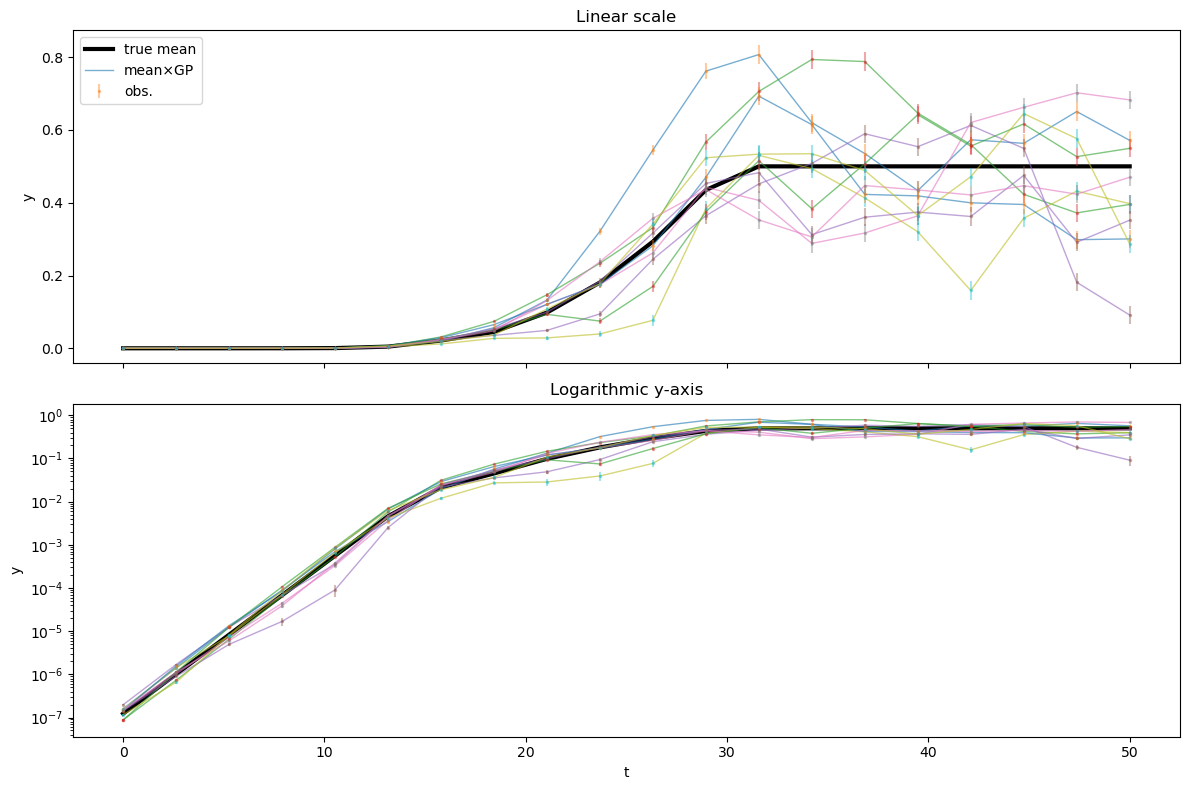

100%|██████████| 4500/4500 [00:23<00:00, 187.61it/s]


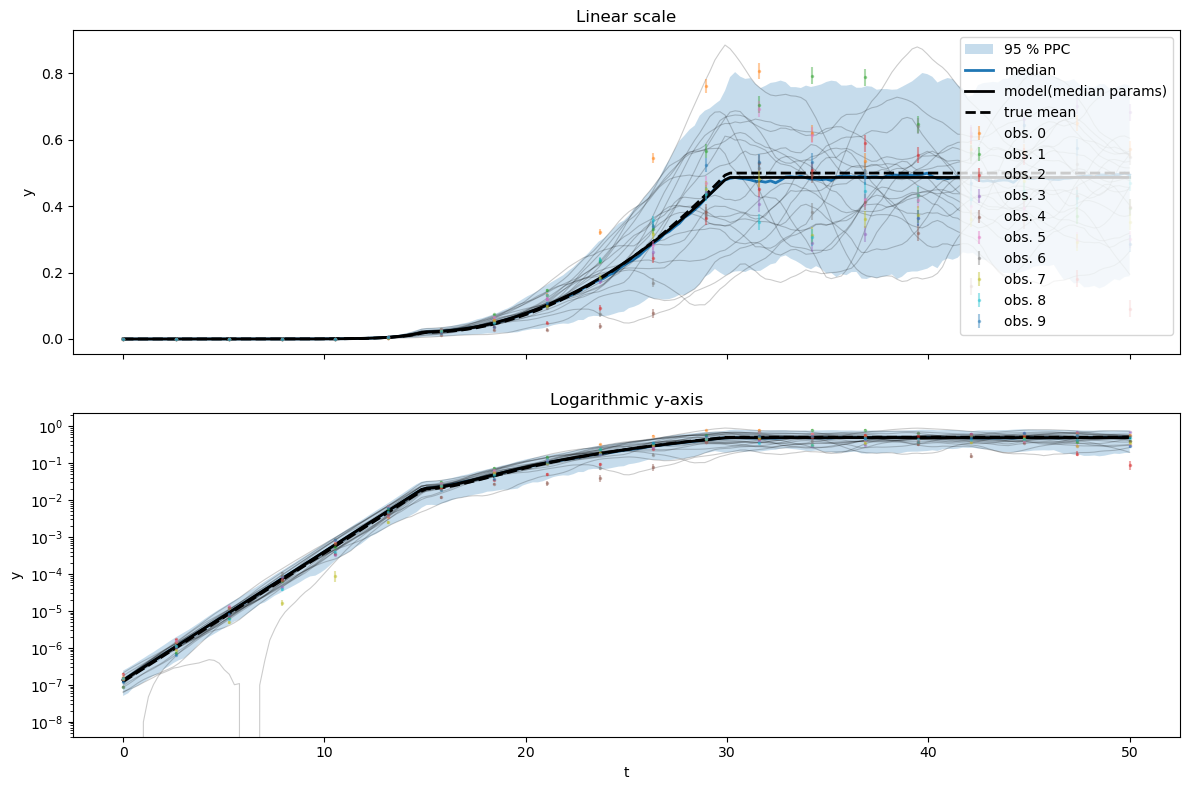

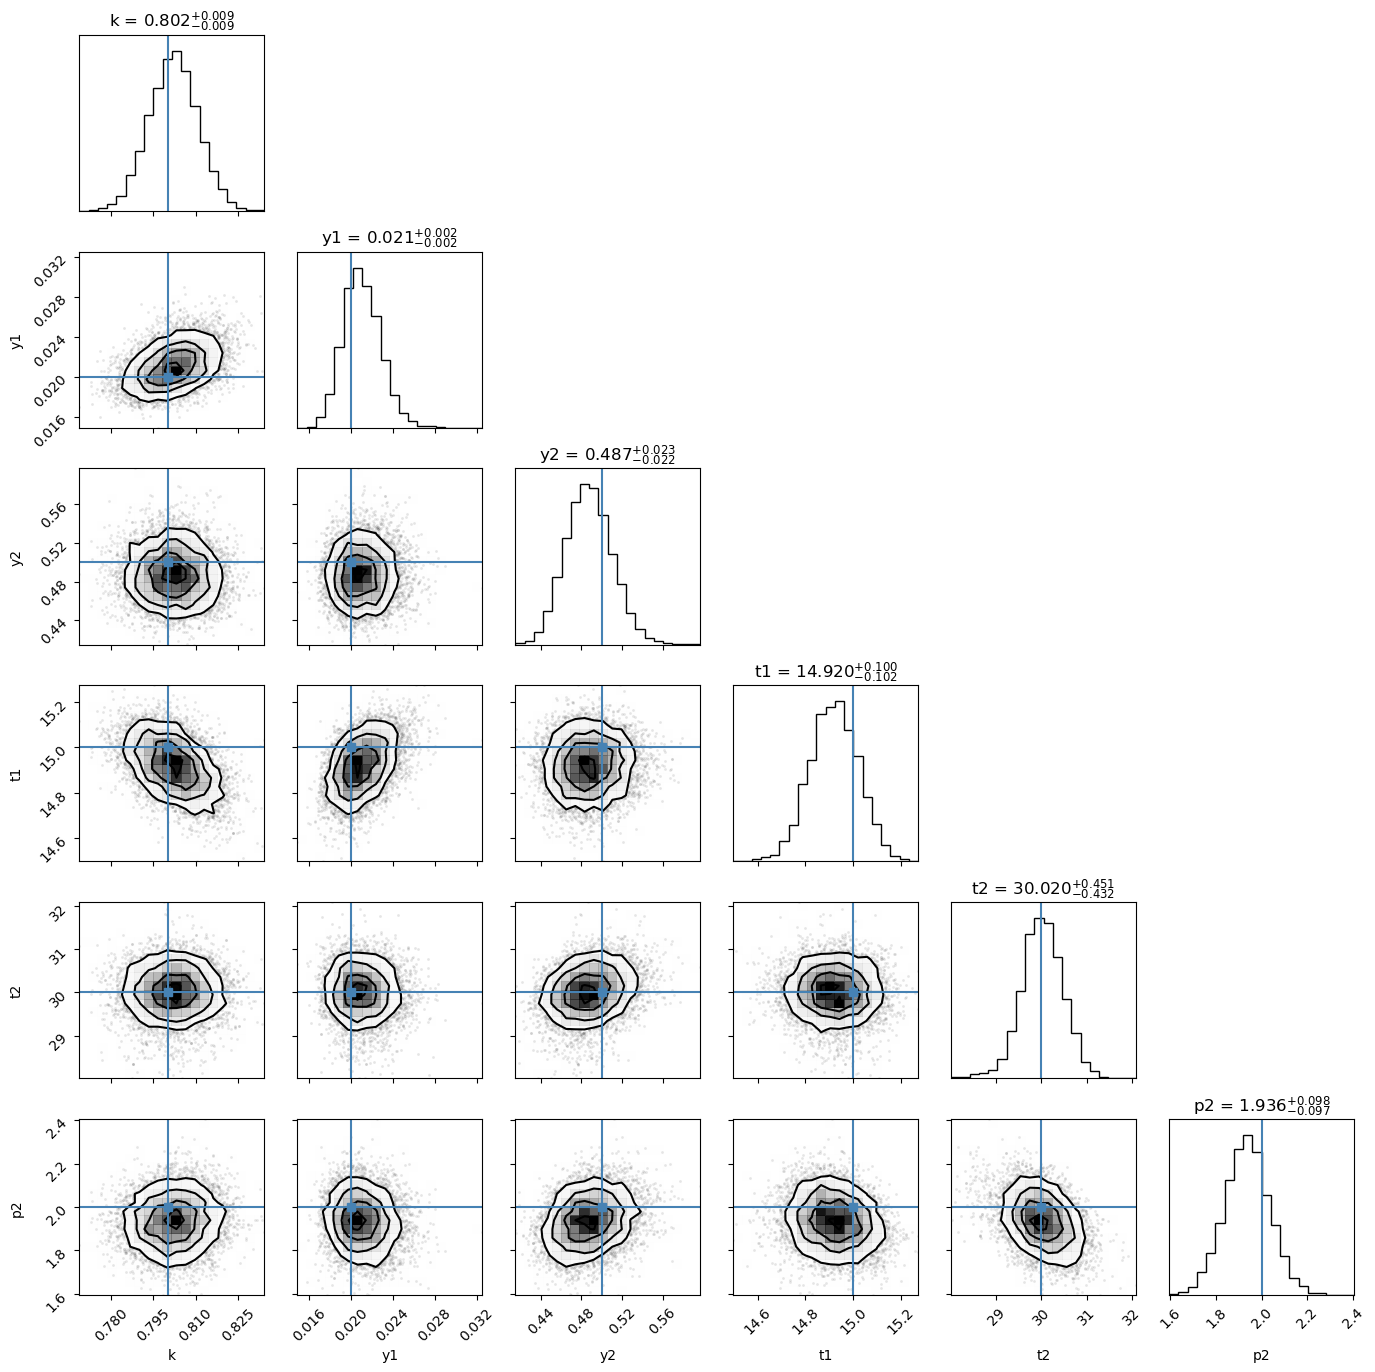

In [11]:
from __future__ import annotations
import numpy as np
from numpy.typing import ArrayLike
from scipy.spatial.distance import cdist
from scipy.linalg import cho_factor, cho_solve, LinAlgError
import matplotlib.pyplot as plt
import emcee, corner

# ───────────────────────────────────────────────
# 0.  Hyper-parameters (fixed)
# ───────────────────────────────────────────────
SIGMA_F = 0.3          # GP amplitude
ELL     = 5.0           # GP length-scale
SIGMA_N = 0.05          # multiplicative white-noise σ_n
N_REP   = 10
PARAM_NAMES = ("k", "y1", "y2", "t1", "t2", "p2")
NDIM = len(PARAM_NAMES)

rng = np.random.default_rng(2025)      # reproducible RNG

# ───────────────────────────────────────────────
# 1.  Mean function (re-parametrised + correct p1)
# ───────────────────────────────────────────────
def mean_exp_pow_flat(
    t: ArrayLike,
    k:   float,
    y1:  float,
    y2:  float,
    t1:  float,
    t2:  float,
    p2:  float,
) -> np.ndarray:
    """
    0 ≤ t < t1       :  y0 · exp(k t)
    t1 ≤ t < t2      :  y_base(t1) + p1·(t−t1)^p2
    t ≥ t2           :  y2
    where:
      y0 = y1 * exp(-k*t1)
      y_base(t) = y0 * exp(k t)
      y_base(t1) = y0 * exp(k*t1)
      p1 = (y2 − y_base(t1)) / (t2 − t1)^p2
    """
    t = np.asarray(t, float)
    m = np.empty_like(t)

    # derive y0 so that y_base(t1)=y1
    y0 = y1 * np.exp(-k * t1)

    # full exponential baseline
    y_base = y0 * np.exp(np.clip(k * t, -700.0, 700.0))

    # compute y_base at t1 and the polynomial amplitude p1
    y_base_t1 = y0 * np.exp(np.clip(k * t1, -700.0, 700.0))
    p1 = (y2 - y_base_t1) / (t2 - t1)**p2

    seg1 = t < t1
    seg2 = (t >= t1) & (t < t2)
    seg3 = t >= t2

    if seg1.any():
        m[seg1] = y_base[seg1]
    if seg2.any():
        m[seg2] = y_base_t1 + p1 * np.power(t[seg2] - t1, p2)
    if seg3.any():
        m[seg3] = y2

    return m

def matern32(pdist: ArrayLike, sigma_f: float, ell: float) -> np.ndarray:
    r = np.sqrt(3.0) * pdist / ell
    return sigma_f**2 * (1.0 + r) * np.exp(-r)

# ───────────────────────────────────────────────
# 2.  Priors & likelihood
# ───────────────────────────────────────────────
def log_prior(theta: ArrayLike) -> float:
    """
    Uniform priors —
      k     ~ U(0.1, 10)
      y1,y2 ~ U(0, 1)
      t1,t2 ~ U(0, 100)  with  t2 > t1
      p2    ~ U(0.25, 4)
    """
    k, y1, y2, t1, t2, p2 = theta

    # support checks
    if not (0.1 <= k <= 10.0):
        return -np.inf
    if not (0.0 <= y1 <= 1.0 and 0.0 <= y2 <= 1.0):
        return -np.inf
    if not (0.0 <= t1 <= 100.0 and 0.0 <= t2 <= 100.0 and t2 > t1):
        return -np.inf
    if not (0.25 <= p2 <= 4.0):
        return -np.inf

    # All PDFs are constant inside the admissible region → log-prior is a constant.
    # Returning 0 is sufficient because any additive constant cancels in MCMC.
    return 0.0

def log_likelihood(theta: ArrayLike,
                   t: ArrayLike,
                   Y: ArrayLike) -> float:
    k, y1, y2, t1, t2, p2 = theta
    t = np.asarray(t, float)
    Y = np.asarray(Y, float)  # shape (N_REP, n_t)

    # mean & residuals
    m = mean_exp_pow_flat(t, k, y1, y2, t1, t2, p2)
    R = Y - m

    # covariance: Σ = diag(m) K diag(m) + σ_n² diag(m²)
    pd     = cdist(t[:, None], t[:, None])
    K_base = matern32(pd, SIGMA_F, ELL)
    Σ_GP   = K_base * np.outer(m, m)
    Σ_eps  = (SIGMA_N**2) * np.diag(m**2)
    Σ_y    = Σ_GP + Σ_eps

    try:
        c, lower = cho_factor(Σ_y, lower=True, check_finite=False)
        logdet   = 2.0 * np.sum(np.log(np.diag(c)))
        quad = 0.0
        for j in range(N_REP):
            α     = cho_solve((c, lower), R[j], check_finite=False)
            quad += R[j] @ α
        ll  = -0.5 * quad
        ll += -0.5 * N_REP * (logdet + len(t)*np.log(2*np.pi))
        return ll
    except LinAlgError:
        return -np.inf

def log_posterior(theta: ArrayLike,
                  t: ArrayLike,
                  Y: ArrayLike) -> float:
    lp = log_prior(theta)
    return lp + log_likelihood(theta, t, Y) if np.isfinite(lp) else -np.inf

# ───────────────────────────────────────────────
# 3.  GP sampler (synthetic data & PPC)
# ───────────────────────────────────────────────
def gp_sample(t: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    K = matern32(cdist(t[:, None], t[:, None]), SIGMA_F, ELL)
    return rng.multivariate_normal(np.zeros(len(t)), K)

# ───────────────────────────────────────────────
# 4.  Synthetic data
# ───────────────────────────────────────────────

theta_true = np.array([0.8,    0.02, 0.5, 15.0, 30.0, 2.0])
# parameters are:     [exponent, y1,  y2,   t1,   t2,  p2]
t = np.linspace(0, 50, 20)
m_true = mean_exp_pow_flat(t, *theta_true)

Y_clean = np.empty((N_REP, len(t)))
for j in range(N_REP):
    Y_clean[j] = m_true * (1.0 + gp_sample(t, rng))
yerr = SIGMA_N * m_true
Y    = Y_clean

# ───────────────────────────────────────────────
# 5.  Visualise data
# ───────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Upper (linear) plot
ax = axes[0]
ax.plot(t, m_true, 'k-', lw=3, label="true mean")
for j in range(N_REP):
    ax.plot(t, Y_clean[j], lw=1, alpha=0.6,
            label="mean×GP" if j == 0 else None)
    ax.errorbar(t, Y[j], yerr, fmt='.', ms=3, alpha=0.4,
                label="obs." if j == 0 else None)
ax.set_ylabel("y")
ax.legend(loc="upper left")
ax.set_title("Linear scale")

# Lower (log-y) plot
ax = axes[1]
ax.plot(t, m_true, 'k-', lw=3)
for j in range(N_REP):
    ax.plot(t, Y_clean[j], lw=1, alpha=0.6)
    ax.errorbar(t, Y[j], yerr, fmt='.', ms=3, alpha=0.4)
ax.set_yscale('log')
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("Logarithmic y-axis")

plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────
# 6.  emcee sampling
# ───────────────────────────────────────────────
nwalkers = 4 * NDIM
p0 = theta_true + 1e-3 * rng.standard_normal((nwalkers, NDIM))
sampler = emcee.EnsembleSampler(nwalkers, NDIM, log_posterior, args=(t, Y))
sampler.run_mcmc(p0, 4500, progress=True)

burn, thin = 1500, 10
flat = sampler.get_chain(discard=burn, thin=thin, flat=True)

# ───────────────────────────────────────────────
# 7.  Posterior predictive check (one rep)
# ───────────────────────────────────────────────

t_pred = np.linspace(0, 50, 200)
m_true_pred = mean_exp_pow_flat(t_pred, *theta_true)
draws = []
idx = rng.choice(len(flat), 200, replace=False)
for i in idx:
    m_i  = mean_exp_pow_flat(t_pred, *flat[i])
    gp_i = gp_sample(t_pred, rng)
    draws.append(m_i * (1.0 + gp_i))
draws = np.asarray(draws)
med  = np.median(draws, axis=0)
lo95 = np.percentile(draws, 2.5, axis=0)
hi95 = np.percentile(draws, 97.5, axis=0)

theta_median = np.median(flat, axis=0)
m_median_model = mean_exp_pow_flat(t_pred, *theta_median)
# ───────────────────────────────────────────────

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Upper (linear) panel
ax = axes[0]
ax.fill_between(t_pred, lo95, hi95, alpha=0.25, label="95 % PPC")
ax.plot(t_pred, med, lw=2, label="median")
ax.plot(t_pred, m_median_model, 'k-', lw=2, label="model(median params)")
ax.plot(t_pred, m_true_pred, 'k--', lw=2, label="true mean")
for d in draws[:20]:
    ax.plot(t_pred, d, lw=0.8, alpha=0.2, color='k')
for j in range(N_REP):
    ax.errorbar(t, Y[j], yerr, fmt='.', ms=3, alpha=0.4, label=f"obs. {j}")
ax.set_ylabel("y")
ax.set_title("Linear scale")
ax.legend(loc="upper right")

# Lower (log-y) panel
ax = axes[1]
ax.fill_between(t_pred, lo95, hi95, alpha=0.25)
ax.plot(t_pred, med, lw=2)
ax.plot(t_pred, m_median_model, 'k-', lw=2)
ax.plot(t_pred, m_true_pred, 'k--', lw=2)
for d in draws[:20]:
    ax.plot(t_pred, d, lw=0.8, alpha=0.2, color='k')
for j in range(N_REP):
    ax.errorbar(t, Y[j], yerr, fmt='.', ms=3, alpha=0.4, label=f"obs. {j}")

ax.set_yscale('log')
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("Logarithmic y-axis")

plt.tight_layout()
plt.show()


# ───────────────────────────────────────────────
# 8.  Corner plot
# ───────────────────────────────────────────────
corner.corner(flat, labels=PARAM_NAMES,
              truths=theta_true, show_titles=True, title_fmt=".3f")
plt.tight_layout(); plt.show()


### Irregular times

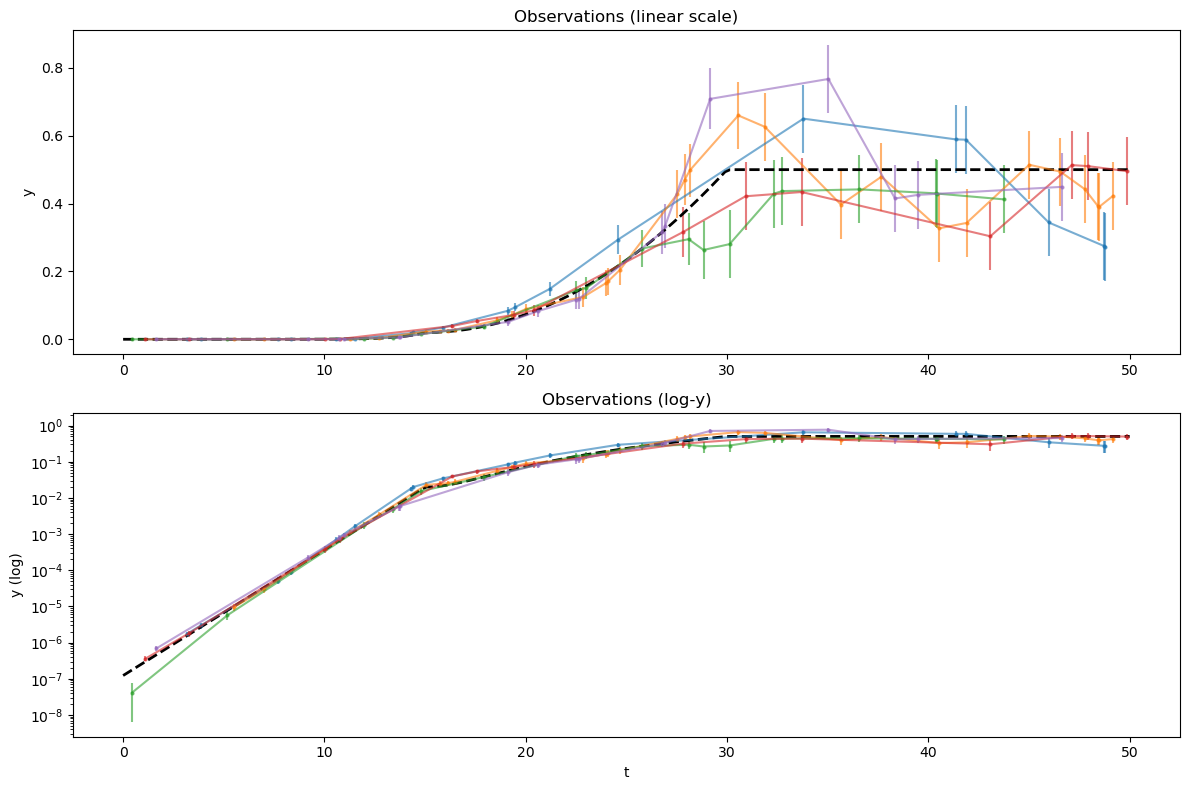

100%|██████████| 4500/4500 [01:10<00:00, 64.24it/s]


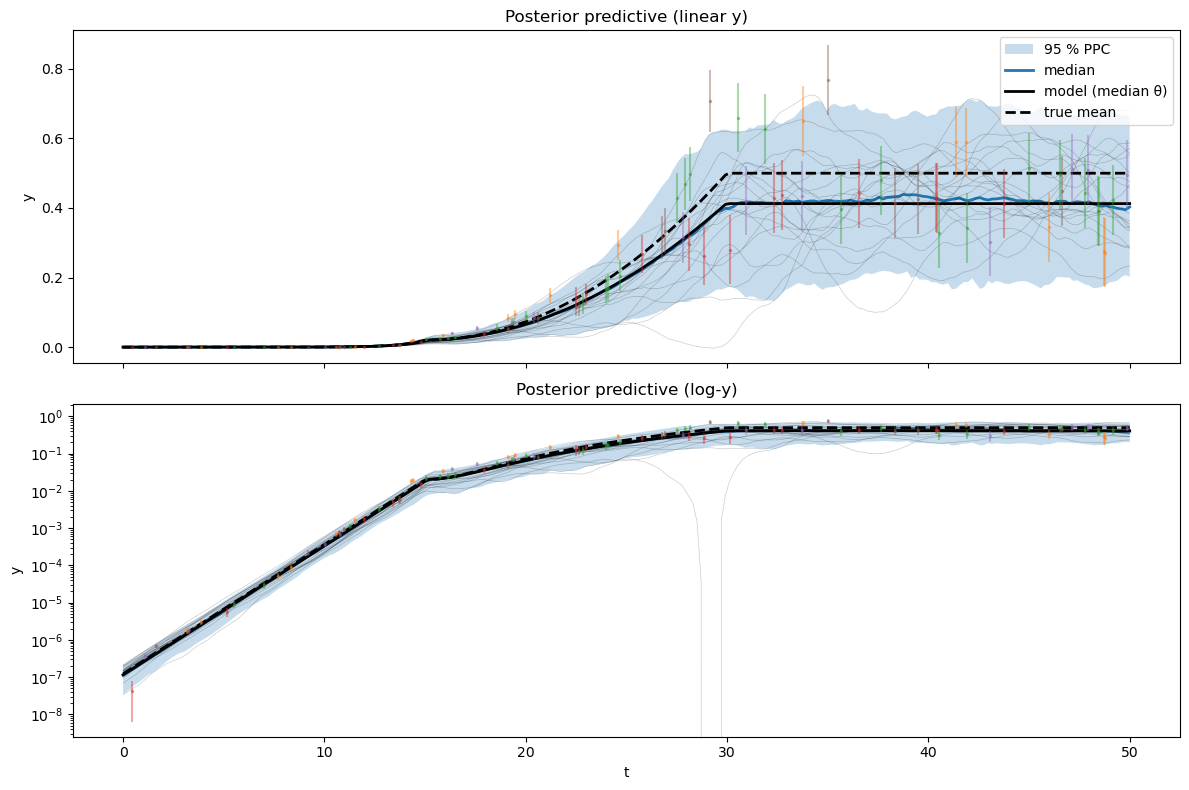

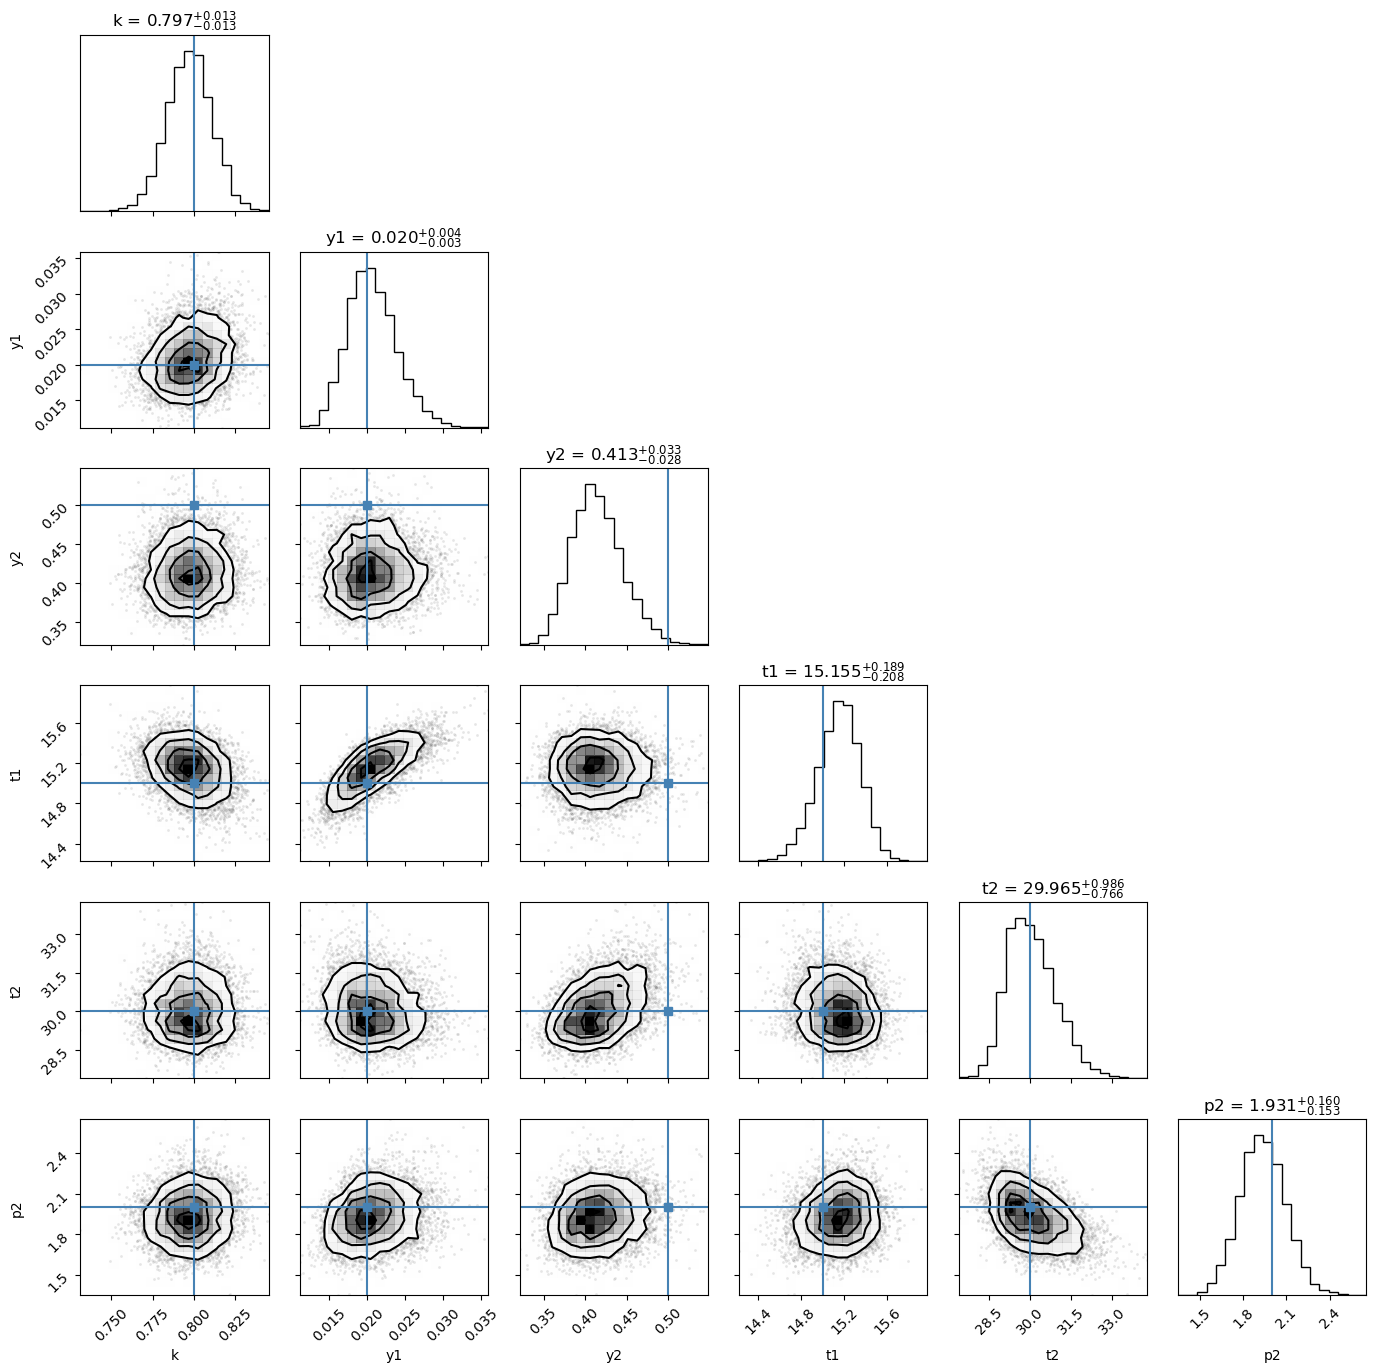

In [10]:
#!/usr/bin/env python
# coding: utf-8
"""
Generalised GP toy-model:
* N_REP independent realisations
* each realisation j observed on its own irregular time grid t_list[j]
  - n_j ~ Uniform{10 … 30}
  - t_j ~ Uniform(0, 30)  (sorted for neat plots only)
"""

from __future__ import annotations

# ───────────────────────────────────────────────
# 0.  Imports & hyper-parameters
# ───────────────────────────────────────────────
import numpy as np
from numpy.typing import ArrayLike
from scipy.spatial.distance import cdist
from scipy.linalg import cho_factor, cho_solve, LinAlgError
import matplotlib.pyplot as plt
import emcee, corner

SIGMA_F = 0.3        # GP amplitude
ELL     = 5.0        # GP length-scale
SIGMA_N = 0.2       # multiplicative white-noise σ_n
N_REP   = 5          # number of independent realisations

PARAM_NAMES = ("k", "y1", "y2", "t1", "t2", "p2")
NDIM = len(PARAM_NAMES)

rng = np.random.default_rng(2025)  # reproducible RNG

# ───────────────────────────────────────────────
# 1.  Mean function & kernel
# ───────────────────────────────────────────────
def mean_exp_pow_flat(
    t: ArrayLike,
    k:  float,
    y1: float,
    y2: float,
    t1: float,
    t2: float,
    p2: float,
) -> np.ndarray:
    """
    Piece-wise mean:

      0 ≤ t < t1   : y0 · exp(k t)
      t1 ≤ t < t2  : y_base(t1) + p1·(t − t1)^p2
      t ≥ t2       : y2

      y0 chosen so that y_base(t1) = y1
      p1 chosen so that mean joins continuously at t2.
    """
    t = np.asarray(t, float)
    m = np.empty_like(t)

    # derive y0 so that y_base(t1) = y1
    y0 = y1 * np.exp(-k * t1)

    # full exponential baseline
    y_base = y0 * np.exp(np.clip(k * t, -700.0, 700.0))

    # y_base at t1 and polynomial amplitude p1
    y_base_t1 = y0 * np.exp(np.clip(k * t1, -700.0, 700.0))
    p1 = (y2 - y_base_t1) / (t2 - t1) ** p2

    seg1 = t < t1
    seg2 = (t >= t1) & (t < t2)
    seg3 = t >= t2

    if seg1.any():
        m[seg1] = y_base[seg1]
    if seg2.any():
        m[seg2] = y_base_t1 + p1 * np.power(t[seg2] - t1, p2)
    if seg3.any():
        m[seg3] = y2
    return m


def matern32(pdist: ArrayLike, sigma_f: float, ell: float) -> np.ndarray:
    r = np.sqrt(3.0) * pdist / ell
    return sigma_f ** 2 * (1.0 + r) * np.exp(-r)

# ───────────────────────────────────────────────
# 2.  Priors, likelihood, posterior
# ───────────────────────────────────────────────
def log_prior(theta: ArrayLike) -> float:
    """
    Uniform priors —
      k     ~ U(0.1, 10)
      y1,y2 ~ U(0, 1)
      t1,t2 ~ U(0, 100)  with  t2 > t1
      p2    ~ U(0.25, 4)
    """
    k, y1, y2, t1, t2, p2 = theta

    # support checks
    if not (0.1 <= k <= 10.0):
        return -np.inf
    if not (0.0 <= y1 <= 1.0 and 0.0 <= y2 <= 1.0):
        return -np.inf
    if not (0.0 <= t1 <= 100.0 and 0.0 <= t2 <= 100.0 and t2 > t1):
        return -np.inf
    if not (0.25 <= p2 <= 4.0):
        return -np.inf

    # All PDFs are constant inside the admissible region → log-prior is a constant.
    # Returning 0 is sufficient because any additive constant cancels in MCMC.
    return 0.0


def log_likelihood(
    theta: ArrayLike,
    t_list: list[np.ndarray],
    Y: list[np.ndarray],
) -> float:
    """Sum of log-likelihoods over independent replicates."""
    k, y1, y2, t1, t2, p2 = theta
    ll_total = 0.0

    for t, y in zip(t_list, Y):
        m  = mean_exp_pow_flat(t, k, y1, y2, t1, t2, p2)
        R  = y - m
        pd = cdist(t[:, None], t[:, None])
        Kb = matern32(pd, SIGMA_F, ELL)
        Σ  = Kb * np.outer(m, m) + (SIGMA_N ** 2) * np.diag(m ** 2)

        try:
            c, low  = cho_factor(Σ, lower=True, check_finite=False)
            α       = cho_solve((c, low), R, check_finite=False)
            logdet  = 2.0 * np.sum(np.log(np.diag(c)))
            quad    = R @ α
            ll_total += -0.5 * (quad + logdet + len(t) * np.log(2 * np.pi))
        except LinAlgError:
            return -np.inf
    return ll_total


def log_posterior(
    theta: ArrayLike,
    t_list: list[np.ndarray],
    Y: list[np.ndarray],
) -> float:
    lp = log_prior(theta)
    return lp + log_likelihood(theta, t_list, Y) if np.isfinite(lp) else -np.inf

# ───────────────────────────────────────────────
# 3.  GP helper for synthetic draws
# ───────────────────────────────────────────────
def gp_sample(t: np.ndarray, rng_: np.random.Generator) -> np.ndarray:
    K = matern32(cdist(t[:, None], t[:, None]), SIGMA_F, ELL)
    return rng_.multivariate_normal(np.zeros(len(t)), K)

# ───────────────────────────────────────────────
# 4.  Synthetic data: random times per replicate
# ───────────────────────────────────────────────
theta_true = np.array([0.8, 0.02, 0.5, 15.0, 30.0, 2.0])
#              [k,  y1,  y2,  t1,   t2,   p2]

t_list:      list[np.ndarray] = []
Y_clean:     list[np.ndarray] = []
yerr_list:   list[np.ndarray] = []

for _ in range(N_REP):
    n_pts = rng.integers(10, 31)                     # 10 … 30 points
    t_j   = np.sort(rng.uniform(0.0, 50.0, n_pts))   # observation times
    m_j   = mean_exp_pow_flat(t_j, *theta_true)
    y_j   = m_j * (1.0 + gp_sample(t_j, rng))        # mean × GP realisation
    t_list.append(t_j)
    Y_clean.append(y_j)
    yerr_list.append(SIGMA_N * m_j)

Y = Y_clean  # convenience alias for later code

# ───────────────────────────────────────────────
# 5.  Visualise observations
# ───────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 8))

# Linear-scale panel
ax = axes[0]
for t_j, y_j, err_j in zip(t_list, Y, yerr_list):
    ax.errorbar(t_j, y_j, err_j, fmt='.-', ms=4, alpha=0.6)

t_dense = np.linspace(0, 50, 200)
ax.plot(t_dense, mean_exp_pow_flat(t_dense, *theta_true), 'k--', lw=2)
ax.set_ylabel("y")
ax.set_title("Observations (linear scale)")

# Log-y panel
ax = axes[1]
for t_j, y_j, err_j in zip(t_list, Y, yerr_list):
    ax.errorbar(t_j, y_j, err_j, fmt='.-', ms=4, alpha=0.6)
ax.plot(t_dense, mean_exp_pow_flat(t_dense, *theta_true), 'k--', lw=2)
ax.set_yscale('log')
ax.set_xlabel("t")
ax.set_ylabel("y (log)")
ax.set_title("Observations (log-y)")

plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────
# 6.  emcee sampling
# ───────────────────────────────────────────────
nwalkers = 4 * NDIM
p0 = theta_true + 1e-3 * rng.standard_normal((nwalkers, NDIM))

sampler = emcee.EnsembleSampler(
    nwalkers, NDIM, log_posterior, args=(t_list, Y)
)
sampler.run_mcmc(p0, 4500, progress=True)

burn, thin = 1500, 10
flat = sampler.get_chain(discard=burn, thin=thin, flat=True)

# ───────────────────────────────────────────────
# 7.  Posterior predictive check (using first replicate’s grid)
# ───────────────────────────────────────────────
t_pred = np.linspace(0, 50, 250)
m_true_pred = mean_exp_pow_flat(t_pred, *theta_true)

draws = []
idx = rng.choice(len(flat), 200, replace=False)
for i in idx:
    m_i  = mean_exp_pow_flat(t_pred, *flat[i])
    gp_i = gp_sample(t_pred, rng)
    draws.append(m_i * (1.0 + gp_i))
draws = np.asarray(draws)
med  = np.median(draws, axis=0)
lo95 = np.percentile(draws, 2.5, axis=0)
hi95 = np.percentile(draws, 97.5, axis=0)

theta_median = np.median(flat, axis=0)
m_median_model = mean_exp_pow_flat(t_pred, *theta_median)

# ───────────────────────────────────────────────
# 8.  Plot posterior predictive vs. data
# ───────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Linear panel
ax = axes[0]
ax.fill_between(t_pred, lo95, hi95, alpha=0.25, label="95 % PPC")
ax.plot(t_pred, med, lw=2, label="median")
ax.plot(t_pred, m_median_model, 'k-', lw=2, label="model (median θ)")
ax.plot(t_pred, m_true_pred, 'k--', lw=2, label="true mean")

for d in draws[:20]:
    ax.plot(t_pred, d, lw=0.5, alpha=0.2, color='k')
for t_j, y_j, err_j in zip(t_list, Y, yerr_list):
    ax.errorbar(t_j, y_j, err_j, fmt='.', ms=3, alpha=0.4)
ax.set_ylabel("y")
ax.set_title("Posterior predictive (linear y)")
ax.legend(loc="upper right")

# Log panel
ax = axes[1]
ax.fill_between(t_pred, lo95, hi95, alpha=0.25)
ax.plot(t_pred, med, lw=2)
ax.plot(t_pred, m_median_model, 'k-', lw=2)
ax.plot(t_pred, m_true_pred, 'k--', lw=2)
for d in draws[:20]:
    ax.plot(t_pred, d, lw=0.5, alpha=0.2, color='k')
for t_j, y_j, err_j in zip(t_list, Y, yerr_list):
    ax.errorbar(t_j, y_j, err_j, fmt='.', ms=3, alpha=0.4)

ax.set_yscale('log')
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("Posterior predictive (log-y)")

plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────
# 9.  Corner plot
# ───────────────────────────────────────────────
corner.corner(
    flat,
    labels=PARAM_NAMES,
    truths=theta_true,
    show_titles=True,
    title_fmt=".3f"
)
plt.tight_layout()
plt.show()
